Starting ACO simulation for path from node 0 to 5...

ACO Simulation Finished.

Starting Dijkstra's algorithm for path from node 0 to 5...

--- Optimization Results Comparison ---
Problem: Find path from node 0 to node 5
Graph: {0: [(1, 1), (2, 5), (3, 8)], 1: [(0, 1), (2, 1), (3, 2), (4, 7)], 2: [(0, 5), (1, 1), (3, 1), (4, 2), (5, 10)], 3: [(0, 8), (1, 2), (2, 1), (4, 1), (5, 3)], 4: [(1, 7), (2, 2), (3, 1), (5, 1)], 5: [(2, 10), (3, 3), (4, 1)]}
------------------------------
ACO Result:
  Path: [0, 1, 3, 4, 5]
  Distance: 5.000
------------------------------
Dijkstra Result (Optimal):
  Path: [0, 1, 2, 4, 5]
  Distance: 5
------------------------------
ACO found a path with the same distance as the optimal path.


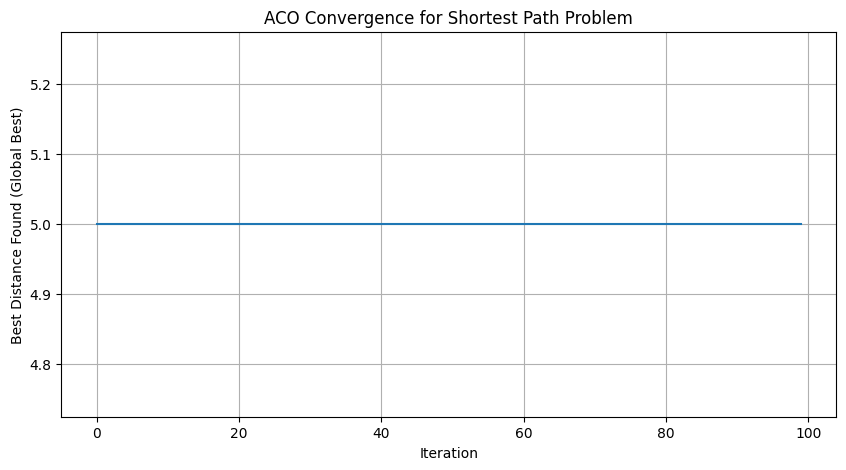

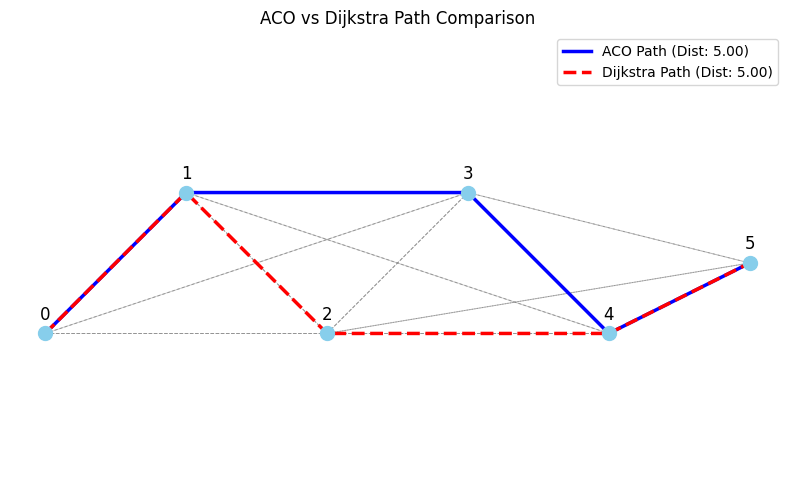

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
import heapq # For Dijkstra's algorithm

# --- 1. Define the Pathfinding Problem (Graph) ---
# Modified graph to introduce more alternative paths and complexity
# This will allow ACO to explore and possibly find different paths than Dijkstra
# and show more variation in convergence

graph = {
    0: [(1, 1), (2, 5), (3, 8)],
    1: [(0, 1), (2, 1), (3, 2), (4, 7)],
    2: [(0, 5), (1, 1), (3, 1), (4, 2), (5, 10)],
    3: [(0, 8), (1, 2), (2, 1), (4, 1), (5, 3)],
    4: [(1, 7), (2, 2), (3, 1), (5, 1)],
    5: [(2, 10), (3, 3), (4, 1)]
}
nodes = list(graph.keys())
num_nodes = len(nodes)

# Define start and end nodes for the pathfinding task
start_node = 0
end_node = 5

# --- 2. ACO Hyperparameters ---
num_ants = 3        # Fewer ants for more randomness
num_iterations = 100 # Fewer iterations for visible change
rho = 0.5           # High evaporation for more exploration
alpha = 0.7         # Lower pheromone influence
beta = 4.0          # Higher heuristic influence
Q = 2.0             # Lower pheromone deposit

# --- 3. Initialize Pheromones and Heuristics ---
# Pheromone trails: tau[i][j] represents the pheromone level on the edge from node i to node j.
# Initialize uniformly with a small amount. A common heuristic is 1 / num_nodes or 1 / (average initial path length).
initial_pheromone = 1.0 # A common initialization value

# Initialize pheromone matrix (symmetric since graph edges are typically bidirectional in pathfinding ACO)
pheromone = np.full((num_nodes, num_nodes), initial_pheromone, dtype=float)

# Heuristic information: eta[i][j] = 1 / distance(i, j). Represents the attractiveness of an edge.
# Use a large value (like infinity or a very large number) for non-existent edges to prevent ants from choosing them.
heuristic = np.zeros((num_nodes, num_nodes), dtype=float)
for u in graph:
    for v, dist in graph[u]:
        if dist > 0: # Avoid division by zero
             heuristic[u][v] = 1.0 / dist
             heuristic[v][u] = 1.0 / dist # Assuming undirected graph heuristic
        else: # Handle zero distance or potential negative (though unlikely in standard TSP/pathfinding)
             heuristic[u][v] = float('inf') # Very high desirability for dist 0
             heuristic[v][u] = float('inf')


# --- 4. Ant Movement Rule ---
def get_next_node(current_node, visited):
    """
    Probabilistically selects the next node for an ant from current_node
    based on pheromone and heuristic information.
    """
    possible_moves = []
    probabilities = []

    # Identify potential next nodes (neighbors not yet visited)
    for neighbor, dist in graph.get(current_node, []):
        if neighbor not in visited:
            possible_moves.append(neighbor)

    # If no valid moves, the ant is stuck
    if not possible_moves:
        return None

    # Calculate the desirability (pheromone^alpha * heuristic^beta) for each possible move
    desirabilities = []
    for next_node in possible_moves:
        tau = pheromone[current_node][next_node] # Pheromone
        eta = heuristic[current_node][next_node] # Heuristic (1/distance)
        desirability = (tau**alpha) * (eta**beta)
        desirabilities.append(desirability)

    total_desirability = sum(desirabilities)

    # If total desirability is zero (e.g., all pheromones/heuristics are zero),
    # choose randomly among possible moves to avoid division by zero and explore.
    if total_desirability == 0:
         probabilities = [1.0 / len(possible_moves)] * len(possible_moves)
    else:
        # Calculate normalized probabilities
        probabilities = [d / total_desirability for d in desirabilities]

    # Select the next node based on the calculated probabilities
    next_node = random.choices(possible_moves, weights=probabilities, k=1)[0]

    return next_node

# --- 5. ACO Solution Construction for Path (Start to End) ---
def construct_path(start, end):
    """
    Simulates a single ant constructing a path from the start node to the end node.
    Returns the path (list of nodes) and its total distance.
    If the ant gets stuck, returns None for path and infinity for distance.
    """
    current_node = start
    path = [current_node]
    visited = {current_node}
    total_dist = 0

    while current_node != end:
        next_node = get_next_node(current_node, visited)

        # Check if the ant got stuck (no valid next moves)
        if next_node is None:
            return None, float('inf') # Ant failed to reach the end

        # Find the distance to the selected next node
        dist_to_next = None
        for neighbor, dist in graph.get(current_node, []):
            if neighbor == next_node:
                dist_to_next = dist
                break # Found the distance

        if dist_to_next is None:
             # This case should ideally not happen if get_next_node selects a valid neighbor
             # but added for robustness. Means the selected neighbor wasn't actually a neighbor.
             return None, float('inf')

        path.append(next_node)
        visited.add(next_node)
        total_dist += dist_to_next
        current_node = next_node

    # Ant successfully reached the end node
    return path, total_dist

# --- 6. Pheromone Update Mechanism ---
def update_pheromones(all_ant_paths, global_best_path_info):
    """
    Updates pheromone trails based on ant paths and evaporation.
    Applies evaporation globally and deposition based on successful ant paths.
    Includes an elitist update for the global best path found so far.
    """
    global pheromone # We need to modify the global pheromone matrix

    # Pheromone Evaporation: Reduce pheromone levels on all edges
    pheromone *= (1 - rho)

    # Pheromone Deposition by individual ants that completed a path
    for path, dist in all_ant_paths:
        if path is not None and dist != float('inf'): # Only deposit if the ant found a valid path
            pheromone_deposit = Q / dist # Amount of pheromone to deposit
            # Deposit pheromone along the edges of the path
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                pheromone[u][v] += pheromone_deposit
                pheromone[v][u] += pheromone_deposit # Symmetric update for undirected graph

    # Elitist Pheromone Deposition (on the best path found globally across all iterations)
    # This reinforces the best solution found so far.
    global_best_path, global_best_dist = global_best_path_info
    if global_best_path is not None and global_best_dist != float('inf'):
        elitist_deposit = Q / global_best_dist # Amount of pheromone for the elitist path
        # Deposit elitist pheromone along the edges of the global best path
        for i in range(len(global_best_path) - 1):
            u, v = global_best_path[i], global_best_path[i+1]
            pheromone[u][v] += elitist_deposit
            pheromone[v][u] += elitist_deposit # Symmetric update


# --- 7. Run ACO ---
def run_aco(start, end):
    """
    Executes the main loop of the Ant Colony Optimization algorithm
    to find the shortest path from start to end.
    """
    global_best_path = None
    global_best_dist = float('inf') # Initialize global best distance to infinity

    best_dist_history = [] # To track the best distance found at the end of each iteration

    for iteration in range(num_iterations):
        # List to store paths found by all ants in the current iteration
        all_ant_paths = []

        # Ant construction phase
        for ant_id in range(num_ants):
            path, dist = construct_path(start, end)
            all_ant_paths.append((path, dist))

            # Update the best path found in the current iteration
            if path is not None and dist < global_best_dist:
                 global_best_dist = dist
                 global_best_path = path

        # Update pheromone trails after all ants have moved
        update_pheromones(all_ant_paths, (global_best_path, global_best_dist))

        # Record the global best distance after this iteration
        best_dist_history.append(global_best_dist)

        # Optional: Print progress of the best distance
        # if (iteration + 1) % 10 == 0 or iteration == 1:
        #     print(f"Iteration {iteration+1}: Global Best Distance = {global_best_dist:.3f}")

    print("\nACO Simulation Finished.")
    return global_best_path, global_best_dist, best_dist_history

# --- 8. Dijkstra's Algorithm (for comparison) ---
def dijkstra(graph, start, end):
    """
    Finds the shortest path from start to end using Dijkstra's algorithm.
    Requires a graph represented as an adjacency list {node: [(neighbor, weight)]}.
    Returns the path (list of nodes) and the total distance.
    Returns None and float('inf') if the end is unreachable.
    """
    # dists: Dictionary to store the shortest distance found from start to each node.
    # Initialize all distances to infinity except for the start node (distance 0).
    dists = {node: float('inf') for node in graph}
    dists[start] = 0

    # previous: Dictionary to store the predecessor node on the shortest path from start.
    # Used to reconstruct the path.
    previous = {node: None for node in graph}

    # Priority queue: Stores tuples of (distance, node).
    # Automatically sorts by distance, allowing us to always process the node
    # with the smallest known distance first.
    pq = [(0, start)] # Start with the start node and distance 0 in the priority queue

    while pq:
        # Get the node with the smallest distance from the priority queue
        current_dist, current_node = heapq.heappop(pq)

        # If we have reached the end node, reconstruct the path
        if current_node == end:
            path = []
            # Traverse back from the end node to the start using the 'previous' dictionary
            while current_node is not None:
                path.append(current_node)
                current_node = previous[current_node]
            # The path is built backwards, so reverse it
            return path[::-1], dists[end]

        # If the current distance extracted from the priority queue is greater
        # than the already recorded shortest distance to this node, skip.
        # This happens if we found a shorter path to this node earlier.
        if current_dist > dists[current_node]:
            continue

        # Explore the neighbors of the current node
        for neighbor, weight in graph.get(current_node, []):
            # Calculate the distance to the neighbor through the current node
            distance = current_dist + weight

            # If this new path to the neighbor is shorter than the previously known shortest path
            if distance < dists[neighbor]:
                # Update the shortest distance to the neighbor
                dists[neighbor] = distance
                # Set the current node as the predecessor of the neighbor on the shortest path
                previous[neighbor] = current_node
                # Add or update the neighbor in the priority queue with the new shorter distance
                heapq.heappush(pq, (distance, neighbor))

    # If the loop finishes and the end node was not reached, it means the end is unreachable from the start.
    return None, float('inf')


# --- 9. Run Algorithms and Compare ---
print(f"Starting ACO simulation for path from node {start_node} to {end_node}...")
# Run the ACO algorithm
aco_path, aco_dist, aco_history = run_aco(start_node, end_node)

print(f"\nStarting Dijkstra's algorithm for path from node {start_node} to {end_node}...")
# Run Dijkstra's algorithm for comparison (ground truth)
dijkstra_path, dijkstra_dist = dijkstra(graph, start_node, end_node)

print("\n--- Optimization Results Comparison ---")
print(f"Problem: Find path from node {start_node} to node {end_node}")
print(f"Graph: {graph}")
print("-" * 30)
print(f"ACO Result:")
print(f"  Path: {aco_path}")
print(f"  Distance: {aco_dist:.3f}") # Print with 3 decimal places for clarity
print("-" * 30)
print(f"Dijkstra Result (Optimal):")
print(f"  Path: {dijkstra_path}")
print(f"  Distance: {dijkstra_dist}")
print("-" * 30)

# Check if ACO found the optimal path (or a path with the optimal distance)
if aco_dist == dijkstra_dist:
    print("ACO found a path with the same distance as the optimal path.")
elif aco_dist < dijkstra_dist:
     print("Warning: ACO found a path shorter than Dijkstra's? Check graph or implementations.")
else:
    # Allow for small floating point inaccuracies in ACO distance calculation if needed
    if abs(aco_dist - dijkstra_dist) < 1e-9:
         print("ACO found a path with a distance very close to the optimal path (due to floating point arithmetic).")
    else:
        print(f"ACO found a path, but it is longer than the optimal path by {aco_dist - dijkstra_dist:.3f}.")
        print("This is expected as ACO is a metaheuristic and doesn't guarantee optimality.")

# --- 10. Plotting Convergence (ACO) ---
plt.figure(figsize=(10, 5))
plt.plot(range(len(aco_history)), aco_history)
plt.xlabel("Iteration")
plt.ylabel("Best Distance Found (Global Best)")
plt.title("ACO Convergence for Shortest Path Problem")
plt.grid(True)
plt.show()

# --- Optional: Plotting the Graph and Paths ---
# Update node positions for visualization (spread out for clarity)
pos = {
    0: (0, 0),
    1: (2, 2),
    2: (4, 0),
    3: (6, 2),
    4: (8, 0),
    5: (10, 1)
}

plt.figure(figsize=(10, 6))

# Draw nodes
for node, coords in pos.items():
    plt.plot(coords[0], coords[1], 'o', markersize=10, color='skyblue', zorder=5) # zorder to be on top
    plt.text(coords[0], coords[1] + 0.2, str(node), fontsize=12, ha='center')

# Draw all edges in the graph faintly
for u in graph:
    for v, dist in graph[u]:
        x_coords = [pos[u][0], pos[v][0]]
        y_coords = [pos[u][1], pos[v][1]]
        plt.plot(x_coords, y_coords, 'gray', linestyle='--', linewidth=0.7, alpha=0.6) # Faint dashed lines

# Draw ACO Path
if aco_path is not None and aco_dist != float('inf'):
    aco_x = [pos[node][0] for node in aco_path]
    aco_y = [pos[node][1] for node in aco_path]
    plt.plot(aco_x, aco_y, 'b-', linewidth=2.5, label=f'ACO Path (Dist: {aco_dist:.2f})', zorder=2) # Solid blue line

# Draw Dijkstra Path
if dijkstra_path is not None and dijkstra_dist != float('inf'):
    dij_x = [pos[node][0] for node in dijkstra_path]
    dij_y = [pos[node][1] for node in dijkstra_path]
    plt.plot(dij_x, dij_y, 'r--', linewidth=2.5, label=f'Dijkstra Path (Dist: {dijkstra_dist:.2f})', zorder=3) # Dashed red line

plt.title('ACO vs Dijkstra Path Comparison')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(False) # Hide grid for graph plot
plt.axis('equal') # Equal scaling for x and y axes
plt.axis('off') # Hide axes ticks and labels
plt.show()